In [17]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping


In [25]:
import cv2
import os
import numpy as np

def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + '\\' + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '\\' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [26]:
TRAIN_DIR = 'C:\\Users\\Joeri Van Cauwelaert\\Desktop\\Masterthesis\\machineLearning\\SplittedImages\\train'
TEST_DIR = 'C:\\Users\\Joeri Van Cauwelaert\\Desktop\\Masterthesis\\machineLearning\\SplittedImages\\test'
VAL_DIR = 'C:\\Users\\Joeri Van Cauwelaert\\Desktop\\Masterthesis\\machineLearning\\SplittedImages\\val'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.88s/it]


1440 images loaded from C:\Users\Joeri Van Cauwelaert\Desktop\Masterthesis\machineLearning\SplittedImages\train directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.41s/it]


480 images loaded from C:\Users\Joeri Van Cauwelaert\Desktop\Masterthesis\machineLearning\SplittedImages\test directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.18s/it]

480 images loaded from C:\Users\Joeri Van Cauwelaert\Desktop\Masterthesis\machineLearning\SplittedImages\val directory.


In [28]:
import matplotlib.pyplot as plt

def plot_samples(X, y, labels_dict, n):
    fig = plt.figure(figsize=(10, 10))
    rows = int(np.ceil(n / 5))
    for i in range(1, n + 1):
        plt.subplot(rows, 5, i)
        plt.imshow(X[i-1])  # Assuming X contains the image data
        plt.title(labels_dict[y[i-1]])
        plt.axis('off')
    plt.show()

# Call the function to plot samples
plot_samples(X_train, y_train, labels, 30)

TypeError: Image data of dtype object cannot be converted to float

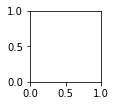

In [30]:
plot_samples(X_train, y_train, labels, 30)

In [32]:
# load base model
#vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


In [51]:


train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    seed=123
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='categorical',
    seed=123
)

Found 1440 images belonging to 4 classes.
Found 480 images belonging to 4 classes.


In [52]:
NUM_CLASSES = 4

# Create a new Sequential model
model = Sequential()

# Add the pre-trained ResNet50 base model
model.add(base_model)

# Flatten the output of the base model
model.add(layers.Flatten())

# Add dropout layer for regularization
model.add(layers.Dropout(0.5))

# Add a dense output layer with softmax activation for multiclass classification
model.add(layers.Dense(units = 4, activation='softmax'))

# Freeze the weights of the base model
model.layers[0].trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [53]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30


C:\Users\Joeri Van Cauwelaert\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 4/50 ━━━━━━━━━━━━━━━━━━━━ 5:52 8s/step - accuracy: 0.3171 - loss: 10.2548

KeyboardInterrupt: 